# Univariate regression - Many to Many

## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import math
from scipy.stats import spearmanr

random_seed = 42

## Data

$$
E(r, t) = E_{0} · cos(\omega t - kr) = E_{0} · cos(2·\pi·f·t - kr)
$$

In [2]:
# E(r, t) = E_0 · cos(wt - kr) = E_0 · cos(2·pi·f·t - kr)
def Wave(e0, f, k, r, t):
    ''' E(r, t) = E_0 · cos(wt - kr) = E_0 · cos(2·pi·f·t - kr)
    '''
    if np.size(r) > 1:
        e = np.empty([len(r), len(t)])
        for i, d in enumerate(r):
            e[i, :] = e0 * np.cos(2*np.pi*f*t - k*d)
    else:
        e = e0 * np.cos(2*np.pi*f*t - k*r)
    return e

In [3]:
def make_data(t, r):
    t = np.arange(0,2,0.001) # Tiempo (stat, stop, step)
    r = np.array([1, 0, 0]) # ejes (x, y, z)
    
    # Creating waves
    waves = []
    waves.append(Wave(t**2, 0, 0, r, t))
    waves.append(Wave(1, 10, 2*np.pi*3/4, r, t))
    waves.append(Wave(1, 15, 0, r, t))

    # Sum waves
    waves.append((waves[0]+waves[1]+waves[2])/3)
    
    return waves

In [4]:
def show_waves(waves, t):
    num_simple_waves = len(waves) - 1
    
    plt.figure("Original_Waves", figsize=(14, 4))
    for i in range(num_simple_waves):
        plt.subplot(num_simple_waves,1,i+1)
        plt.plot(t, waves[i][0])
        
    # Plot - Ondas combinadas
    plt.figure("Sum_Waves", figsize=(14, 4))
    plt.plot(t, waves[i+1][0])

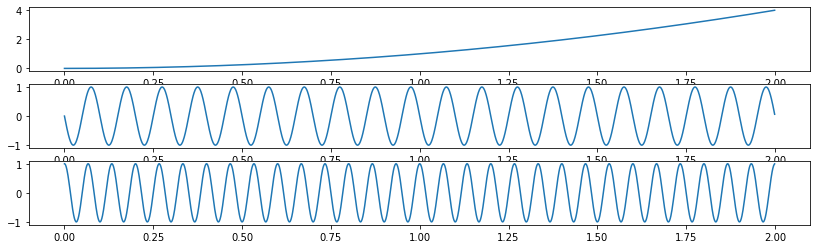

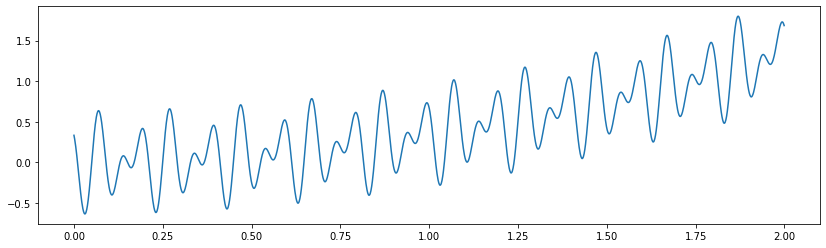

In [5]:
t = np.arange(0,2,0.001) # Tiempo (stat, stop, step)
r = np.array([1, 0, 0]) # ejes (x, y, z)
waves = make_data(t, r)
show_waves(waves, t)

In [6]:
df = pd.DataFrame(waves[-1][0], columns=['seq'], index=t).rename_axis("time")
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2000 entries, 0.0 to 1.999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


In [7]:
df.head()

,seq
time,
0.000,0.333333
0.001,0.310924
0.002,0.285653
0.003,0.257640
0.004,0.227034


## Scaler

In [8]:
scaler = MinMaxScaler()
seq_scaled = pd.Series(
    scaler.fit_transform(df).squeeze(),
    index=df.index)

In [9]:
df['seq_scaled'] = scaler.fit_transform(df['seq'].values.reshape(-1,1))
df.head()

,seq,seq_scaled
time,,
0.000,0.333333,0.397704
0.001,0.310924,0.388500
0.002,0.285653,0.378120
0.003,0.257640,0.366614
0.004,0.227034,0.354042


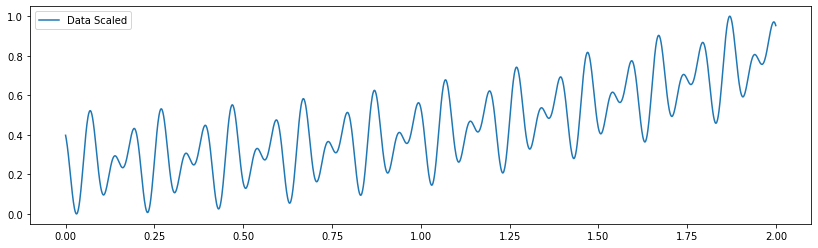

In [10]:
plt.figure("Data", figsize=(14, 4))
plt.plot(df['seq_scaled'], label="Data Scaled")
plt.legend()
plt.show()

## Get time series data into shape for an RNN
The input to every LSTM layer must have three dimensions, namely:

* **Batch size**: One sequence is one sample. A batch contains one or more samples.
* **Time steps**: One time step is a single observation in the sample.
* **Features**: One feature is one observation at a time step.

## Univariate rnn data

![Univariate_imagen](https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/raw/d6e03d8a18809fd9a2dffc069a9f19038d6fa8a3/assets/timeseries_windowing.gif)

In [11]:
window_size = 100 # Or lookback, Time steps
n_features = 1
n_outputs = 30

In [12]:
def create_univariate_rnn_data(sequence, window_size, index, n_outputs, index_name=None, is_scaled=True):
    if is_scaled:
        columns=['X_scaled', 'y_scaled']
    else:
        columns=['X', 'y']
    df = pd.DataFrame(columns=columns, index=index[window_size:-n_outputs])
    df[columns[0]] = [sequence[i:i+window_size] for i in range(0, len(sequence)-window_size-n_outputs)]
    df[columns[1]] = [sequence[window_size+i:window_size+i+n_outputs] for i in range(0, len(sequence)-window_size-n_outputs)]
    if index_name:
        df = df.rename_axis("time")
    return df

In [13]:
df_u_rnn = create_univariate_rnn_data(
    sequence=df['seq_scaled'].values , 
    window_size=window_size, 
    index=df.index.values,
    index_name="time",
    n_outputs=n_outputs)
df_u_rnn.head()

,X_scaled,y_scaled
time,,
0.100,"[0.3977044839741495, 0.3884999522790913, 0.378...","[0.1252415319410938, 0.11727966006580967, 0.11..."
0.101,"[0.3884999522790913, 0.37811973979924823, 0.36...","[0.11727966006580967, 0.11056187374155882, 0.1..."
0.102,"[0.37811973979924823, 0.36661377363439807, 0.3...","[0.11056187374155882, 0.10510583516960598, 0.1..."
0.103,"[0.36661377363439807, 0.35404230942767045, 0.3...","[0.10510583516960598, 0.10091834346279077, 0.0..."
0.104,"[0.35404230942767045, 0.34047556180633026, 0.3...","[0.10091834346279077, 0.09799543957025669, 0.0..."


In [14]:
df_u_rnn.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1870 entries, 0.1 to 1.969
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   X_scaled  1870 non-null   object
 1   y_scaled  1870 non-null   object
dtypes: object(2)
memory usage: 43.8+ KB


## Train - Test

In [15]:
# 80% train 20% test
split_percent = 0.80
split = int(split_percent*len(df_u_rnn['X_scaled']))
print("Train: \t{}% \t{} samples ".format(split_percent*100, split))
print("Test: \t{}% \t{} samples ".format(100 - split_percent*100, len(df_u_rnn['X_scaled']) - split))

Train: 	80.0% 	1496 samples 
Test: 	20.0% 	374 samples 


In [16]:
np.stack(df_u_rnn['X_scaled']).shape

(1870, 100)

In [17]:
train_scaled = df_u_rnn.iloc[:split]
test_scaled = df_u_rnn.iloc[split:]
print(train_scaled.shape, test_scaled.shape)

(1496, 2) (374, 2)


In [18]:
# Data
X_train_scaled = np.stack(train_scaled['X_scaled']).reshape(-1, window_size, 1)
y_train_scaled = np.stack(train_scaled['y_scaled'].values)
X_test_scaled = np.stack(test_scaled['X_scaled']).reshape(-1, window_size, 1)
y_test_scaled = np.stack(test_scaled['y_scaled'].values)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1496, 100, 1)
(374, 100, 1)


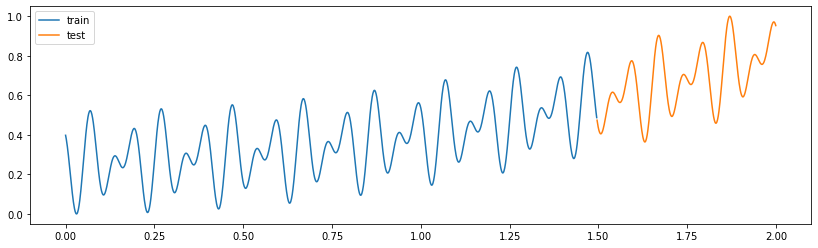

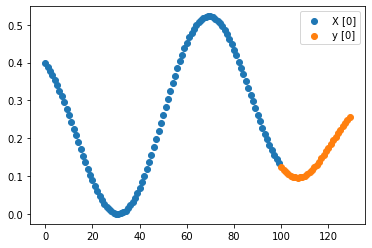

In [19]:
# Train - test
plt.figure("train-test", figsize=(14, 4))
plt.plot(seq_scaled.iloc[:split], label="train")
plt.plot(seq_scaled.iloc[split:], label="test")
plt.legend()
plt.show()
# X - y
plt.scatter(range(0,X_train_scaled[0].shape[0]), X_train_scaled[0], label="X [0]")
plt.scatter(range(X_train_scaled[0].shape[0], X_train_scaled[0].shape[0]+n_outputs), y_train_scaled[0], label="y [0]")
plt.legend()
plt.show()

## RNN

In [20]:
X_train_scaled.shape

(1496, 100, 1)

In [21]:
np.stack(y_train_scaled).shape

(1496, 30)

In [22]:
# Modelo 1 - Vanilla LSTM
rnn = Sequential([
    LSTM(units=50,
         input_shape=(window_size, 1), name='LSTM'),
    Dense(n_outputs, name='Output')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 50)                10400     
                                                                 
 Output (Dense)              (None, 30)                1530      
                                                                 
Total params: 11,930
Trainable params: 11,930
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Modelo 2 - Encoder-Decoder LSTM

In [24]:
rnn2 = Sequential([
    LSTM(units=50,
         input_shape=(window_size, 1), name='LSTM'),
    RepeatVector(n_outputs),
    LSTM(units=50, return_sequences=True),
    TimeDistributed(Dense(1)),
    Activation('linear')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 50)                10400     
                                                                 
 Output (Dense)              (None, 30)                1530      
                                                                 
Total params: 11,930
Trainable params: 11,930
Non-trainable params: 0
_________________________________________________________________


In [25]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                        rho=0.9,
                                        epsilon=1e-08,
                                        decay=0.0)
rnn.compile(loss='mean_squared_error', optimizer=optimizer)
rnn2.compile(loss='mean_squared_error', optimizer=optimizer)

In [26]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

## Train

In [27]:
lstm_training = rnn.fit(X_train_scaled,
                        y_train_scaled,
                        epochs=500,
                        batch_size=20,
                        validation_data=(X_test_scaled, y_test_scaled),
                        callbacks=[early_stopping],
                        verbose=1)

Epoch 1/500
75/75 [==============================] - 4s 22ms/step - loss: 0.0413 - val_loss: 0.0590
Epoch 2/500
75/75 [==============================] - 1s 16ms/step - loss: 0.0231 - val_loss: 0.0760
Epoch 3/500
75/75 [==============================] - 1s 16ms/step - loss: 0.0142 - val_loss: 0.0367
Epoch 4/500
75/75 [==============================] - 1s 17ms/step - loss: 0.0113 - val_loss: 0.0240
Epoch 5/500
75/75 [==============================] - 1s 17ms/step - loss: 0.0089 - val_loss: 0.0478
Epoch 6/500
75/75 [==============================] - 1s 17ms/step - loss: 0.0083 - val_loss: 0.0167
Epoch 7/500
75/75 [==============================] - 1s 17ms/step - loss: 0.0074 - val_loss: 0.0165
Epoch 8/500
75/75 [==============================] - 1s 17ms/step - loss: 0.0067 - val_loss: 0.0158
Epoch 9/500
75/75 [==============================] - 1s 17ms/step - loss: 0.0058 - val_loss: 0.0138
Epoch 10/500
75/75 [==============================] - 1s 17ms/step - loss: 0.0056 - val_loss: 0.0198

Epoch 81/500
75/75 [==============================] - 1s 16ms/step - loss: 4.8545e-04 - val_loss: 0.0051
Epoch 82/500
75/75 [==============================] - 1s 16ms/step - loss: 4.2300e-04 - val_loss: 0.0028
Epoch 83/500
75/75 [==============================] - 1s 17ms/step - loss: 4.4073e-04 - val_loss: 0.0036
Epoch 84/500
75/75 [==============================] - 1s 17ms/step - loss: 3.9945e-04 - val_loss: 0.0032
Epoch 85/500
75/75 [==============================] - 1s 18ms/step - loss: 4.6788e-04 - val_loss: 0.0033
Epoch 86/500
75/75 [==============================] - 1s 17ms/step - loss: 3.8907e-04 - val_loss: 0.0029
Epoch 87/500
75/75 [==============================] - 1s 17ms/step - loss: 4.3153e-04 - val_loss: 0.0039
Epoch 88/500
75/75 [==============================] - 1s 18ms/step - loss: 3.8679e-04 - val_loss: 0.0034
Epoch 89/500
75/75 [==============================] - 1s 17ms/step - loss: 4.1268e-04 - val_loss: 0.0051
Epoch 90/500
75/75 [==============================] - 1

In [28]:
lstm_training2 = rnn2.fit(X_train_scaled,
                        y_train_scaled,
                        epochs=500,
                        batch_size=20,
                        validation_data=(X_test_scaled, y_test_scaled),
                        callbacks=[early_stopping],
                        verbose=1)

Epoch 1/500
75/75 [==============================] - 6s 37ms/step - loss: 0.0349 - val_loss: 0.1685
Epoch 2/500
75/75 [==============================] - 2s 27ms/step - loss: 0.0170 - val_loss: 0.0147
Epoch 3/500
75/75 [==============================] - 2s 26ms/step - loss: 0.0097 - val_loss: 0.0431
Epoch 4/500
75/75 [==============================] - 2s 25ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 5/500
75/75 [==============================] - 2s 25ms/step - loss: 0.0067 - val_loss: 0.0078
Epoch 6/500
75/75 [==============================] - 2s 25ms/step - loss: 0.0062 - val_loss: 0.0165
Epoch 7/500
75/75 [==============================] - 2s 25ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 8/500
75/75 [==============================] - 2s 25ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 9/500
75/75 [==============================] - 2s 26ms/step - loss: 0.0047 - val_loss: 0.0338
Epoch 10/500
75/75 [==============================] - 2s 28ms/step - loss: 0.0044 - val_loss: 0.0055

75/75 [==============================] - 2s 25ms/step - loss: 3.8866e-04 - val_loss: 0.0055
Epoch 81/500
75/75 [==============================] - 2s 26ms/step - loss: 3.6166e-04 - val_loss: 0.0067
Epoch 82/500
75/75 [==============================] - 2s 25ms/step - loss: 4.0092e-04 - val_loss: 0.0104
Epoch 83/500
75/75 [==============================] - 2s 25ms/step - loss: 3.3578e-04 - val_loss: 0.0053
Epoch 84/500
75/75 [==============================] - 2s 25ms/step - loss: 3.8686e-04 - val_loss: 0.0068
Epoch 85/500
75/75 [==============================] - 2s 25ms/step - loss: 3.5249e-04 - val_loss: 0.0089
Epoch 86/500
75/75 [==============================] - 2s 25ms/step - loss: 3.9817e-04 - val_loss: 0.0087
Epoch 87/500
75/75 [==============================] - 2s 26ms/step - loss: 3.5228e-04 - val_loss: 0.0086
Epoch 88/500
75/75 [==============================] - 2s 26ms/step - loss: 3.5140e-04 - val_loss: 0.0104
Epoch 89/500
75/75 [==============================] - 2s 25ms/step -

## Results

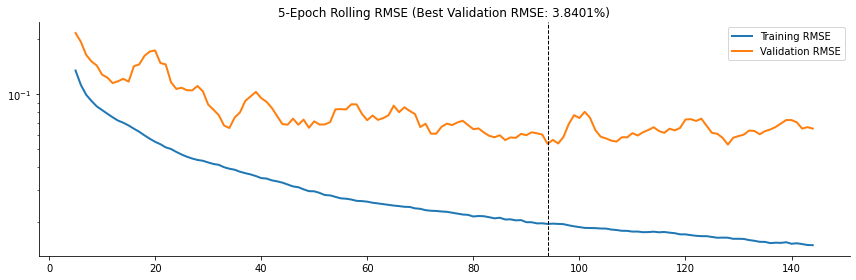

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

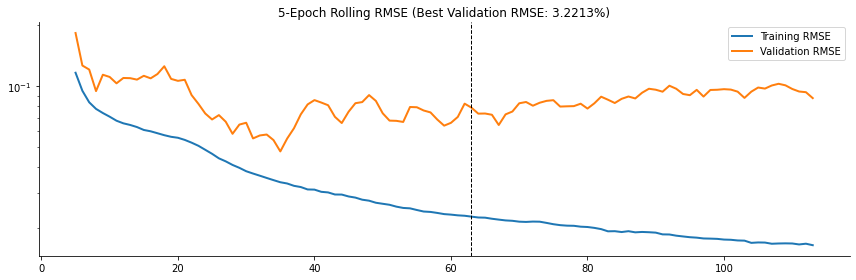

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training2.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [31]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train_scaled, y_train_scaled, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test_scaled, y_test_scaled, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0181 | Test RMSE: 0.0384


In [32]:
train_rmse_scaled = np.sqrt(rnn2.evaluate(X_train_scaled, y_train_scaled, verbose=0))
test_rmse_scaled = np.sqrt(rnn2.evaluate(X_test_scaled, y_test_scaled, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0257 | Test RMSE: 0.0322


In [33]:
train_predict_scaled = rnn.predict(X_train_scaled)
test_predict_scaled = rnn.predict(X_test_scaled)

12/12 [==============================] - 0s 5ms/step


In [34]:
train_predict_scaled_2 = rnn2.predict(X_train_scaled)
test_predict_scaled_2 = rnn2.predict(X_test_scaled)

12/12 [==============================] - 0s 8ms/step


## Rescale predictions

In [35]:
y_train = scaler.inverse_transform(y_train_scaled).squeeze()
y_test = scaler.inverse_transform(y_test_scaled).squeeze()

In [36]:
train_predict = scaler.inverse_transform(train_predict_scaled).squeeze()
test_predict = scaler.inverse_transform(test_predict_scaled).squeeze()
train_predict_2 = scaler.inverse_transform(train_predict_scaled_2.squeeze()).squeeze()
test_predict_2 = scaler.inverse_transform(test_predict_scaled_2.squeeze()).squeeze()

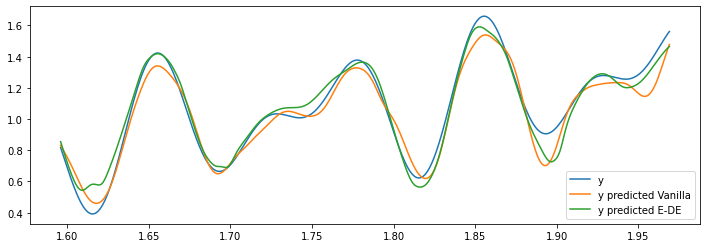

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(test_scaled.index, y_test.mean(axis=1), label="y")
plt.plot(test_scaled.index, test_predict.mean(axis=1), label="y predicted Vanilla")
plt.plot(test_scaled.index, test_predict_2.mean(axis=1), label="y predicted E-DE")
plt.legend()
plt.show()